In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

In [2]:
path = '../input/'
comp = 'germeval2018/'
TRAIN_DATA_FILE=f'{path}{comp}germeval2018.training.txt'
TEST_DATA_FILE=f'{path}{comp}germeval2018.test.txt'

# Preprocessing

In [3]:
import re
import re
import sys


def preprocess_tweet(tweet):
    processed_tweet = []
    # Convert to lower case
    tweet = tweet.lower()
    # Replaces URLs with the word URL
    tweet = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', ' URLTOK ', tweet)
    # Replace @handle with the word USER_MENTION
    tweet = re.sub(r'@[\S]+', 'USRTOK', tweet)
    # Remove RT (retweet)
    tweet = re.sub(r'\brt\b', 'rt', tweet)
    words = tweet.split()

    for word in words:
        processed_tweet.append(word)

    return ' '.join(processed_tweet)

In [4]:
train = pd.read_csv(TRAIN_DATA_FILE, sep="\t", header=None)
#perform binary classification
train = train[[1,0]]
train.columns = ['sentiment', 'tweet_text']
train.applymap(lambda x: x.strip() if type(x) is str else x)
train['tweet_text'] = train['tweet_text'].apply(lambda x: preprocess_tweet(x))

mapping = {'OTHER': 0, 'OFFENSE': 1}
train = train.replace({'sentiment': mapping})
#df_clas_data['sentiment'] = df_clas_data['sentiment'].str.strip()
train['sentiment'] = train['sentiment'].astype(np.float32)

list_sentences_train = train.tweet_text
y = train['sentiment'].values




In [5]:
test = pd.read_csv(TEST_DATA_FILE, sep="\t", header=None)
#perform binary classification
#test = test[[1,0]]
#test.columns = ['sentiment', 'tweet_text']
test.columns = ['tweet_text']


test.applymap(lambda x: x.strip() if type(x) is str else x)
test['tweet_text'] = test['tweet_text'].apply(lambda x: preprocess_tweet(x))



#mapping = {'OTHER': 0, 'OFFENSE': 1}
#test = test.replace({'sentiment': mapping})
#test['sentiment'] = test['sentiment'].astype(np.float32)

list_sentences_test = test.tweet_text
#y_true_test = test.sentiment.values

In [6]:
train.to_csv(f"{path}{comp}Germeval_Data_Train_PreProcessed.csv", index=False)
train['sentiment'].value_counts()

0.0    3321
1.0    1688
Name: sentiment, dtype: int64

In [7]:
test.to_csv(f"{path}{comp}Germeval_Data_Test_PreProcessed.csv", index=False)
len(test['tweet_text'])

3398

There are some very large comments in the dataset (many user mentions)

In [8]:
lens = train.tweet_text.str.len()
lens.mean(), lens.std(), lens.max()

(133.24535835496107, 66.1306696334649, 478)

(array([ 898., 1224., 1791.,  383.,  307.,  339.,   42.,   19.,    3.,
           3.]),
 array([ 27. ,  72.1, 117.2, 162.3, 207.4, 252.5, 297.6, 342.7, 387.8,
        432.9, 478. ]),
 <a list of 10 Patch objects>)

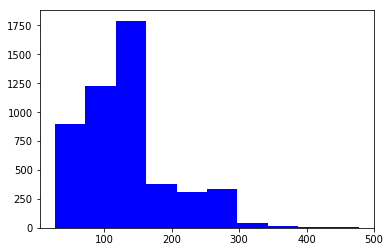

In [9]:
plt.hist(lens, 10, histtype = 'bar', facecolor = 'blue')

# Tokenizing text

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train['tweet_text'])
X_train_counts.shape

(5009, 15347)

In [11]:
#access vocabulary
count_vect.vocabulary_.get('idiot')

6683

# Calculate frequencies

In [12]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf

<5009x15347 sparse matrix of type '<class 'numpy.float64'>'
	with 89215 stored elements in Compressed Sparse Row format>

# SVM-Classifier - 1_grams

In [28]:
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
train = pd.read_csv(f"{path}{comp}Germeval_Data_Train_PreProcessed.csv", sep=",")
test = pd.read_csv(f"{path}{comp}Germeval_Data_Test_PreProcessed.csv", sep=",")

text_clf = Pipeline([('vect', CountVectorizer(ngram_range=(1, 1))),
                     ('tfidf', TfidfTransformer(use_idf=True)), # use_idf=True obtained from GridSearch
                     ('clf', SGDClassifier(loss='log', penalty='l2',max_iter=5, tol=None,random_state=42,alpha=1e-5)),
])
text_clf.fit(train['tweet_text'], train['sentiment'])  

predicted = text_clf.predict(test['tweet_text'])
#print('Accuracy: ' + str(np.mean(predicted == test['sentiment'])))  

In [29]:
len(test)

3398

## Predict probabilities

In [30]:
preds_svm_1_grams = text_clf.predict_proba(test['tweet_text'])

# create a submission
submission = pd.DataFrame(columns=['tweet_text', 'probabilities_neutral', 'probabilities_toxic'])
# read original tweet text
test = pd.read_csv(TEST_DATA_FILE, sep="\t", header=None)
submission['tweet_text'] = test[0].values 
# convert predictions 
submission['probabilities_neutral'] = preds_svm_1_grams[:,0] 
submission['probabilities_toxic'] = preds_svm_1_grams[:,1]
# dummy value
submission.to_csv(f"{path}{comp}SVM_1_grams_probabilities.txt", sep="\t", index=False, header=False)

## perform grid search to optimize parameters

In [31]:
from sklearn.model_selection import GridSearchCV
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'clf__alpha': (1e-2,1e-5, 1e-8),
}
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(train['tweet_text'], train['sentiment'])

In [32]:
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

clf__alpha: 1e-05
tfidf__use_idf: True
vect__ngram_range: (1, 2)


In [33]:
print(gs_clf.predict(['USER_MENTION sarkasmus ist die manchmal letzte sich vor diesem ganzen asyl und migrantenwahnsinn zu']))

[1.]


## Create submission file

In [34]:
# create a submission
submission = pd.DataFrame(columns=['tweet_text', 'binary', 'multiclass'])
# read original tweet text
test = pd.read_csv(TEST_DATA_FILE, sep="\t", header=None)
submission['tweet_text'] = test[0].values 
# convert predictions 
submission['binary'] = predicted 
mapping = {0 :'OTHER', 1: 'OFFENSE'}
submission = submission.replace({'binary': mapping})
# dummy value
submission['multiclass'] = 'OTHER'
submission.to_csv(f"{path}{comp}SVM_1_grams_submit.txt", sep="\t", index=False, header=False)

# SVM-Classifier - 5_grams

In [35]:
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
train = pd.read_csv(f"{path}{comp}Germeval_Data_Train_PreProcessed.csv", sep=",")
test = pd.read_csv(f"{path}{comp}Germeval_Data_Test_PreProcessed.csv", sep=",")

text_clf = Pipeline([('vect', CountVectorizer(ngram_range=(1, 5))),
                     ('tfidf', TfidfTransformer(use_idf=True)), # use_idf=True obtained from GridSearch
                     ('clf', SGDClassifier(loss='log', penalty='l2',max_iter=5, tol=None,random_state=42,alpha=1e-5)),
])
text_clf.fit(train['tweet_text'], train['sentiment'])  

predicted = text_clf.predict(test['tweet_text'])
#print('Accuracy: ' + str(np.mean(predicted == test['sentiment'])))  

In [36]:
#from sklearn.metrics import confusion_matrix, classification_report
#print(classification_report(y_true_test, predicted))

## Predict probabilities

In [37]:
preds_svm_5_grams = text_clf.predict_proba(test['tweet_text'])

# create a submission
submission = pd.DataFrame(columns=['tweet_text', 'probabilities_neutral', 'probabilities_toxic'])
# read original tweet text
test = pd.read_csv(TEST_DATA_FILE, sep="\t", header=None)
submission['tweet_text'] = test[0].values 
# convert predictions 
submission['probabilities_neutral'] = preds_svm_5_grams[:,0] 
submission['probabilities_toxic'] = preds_svm_5_grams[:,1]
# dummy value
submission.to_csv(f"{path}{comp}SVM_5_grams_probabilities.txt", sep="\t", index=False, header=False)

## Create submission file

In [38]:
# create a submission
submission = pd.DataFrame(columns=['tweet_text', 'binary', 'multiclass'])
# read original tweet text
test = pd.read_csv(TEST_DATA_FILE, sep="\t", header=None)
submission['tweet_text'] = test[0].values 
# convert predictions 
submission['binary'] = predicted 
mapping = {0 :'OTHER', 1: 'OFFENSE'}
submission = submission.replace({'binary': mapping})
# dummy value
submission['multiclass'] = 'OTHER'
submission.to_csv(f"{path}{comp}SVM_5_grams_submit.txt", sep="\t", index=False, header=False)

# LSA clustering

In [24]:
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

In [25]:
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )
# this creates a sparse matrix
trn_term_doc = vec.fit_transform(list_sentences_train)
test_term_doc = vec.transform(list_sentences_test)

In [26]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer

lsa = TruncatedSVD(50, algorithm = 'arpack')
dtm_lsa = lsa.fit_transform(trn_term_doc)

dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa)
print(sum(lsa.explained_variance_ratio_))

0.13474835067371033


In [27]:
pd.DataFrame(lsa.components_,columns = vec.get_feature_names())

,!,! !,"! """,! #,! ),! :,! ?,! aber,! alles,! auch,...,😡,😡😡,😡😡😡,😨,😳,🙏,🚂,🤔,🤢,🧐
0,0.181389,0.080846,0.001791,0.005856,0.001191,0.003488,0.005236,0.002452,0.000950,0.001344,...,0.001474,0.001506,0.001528,0.001504,0.001268,0.000823,0.000826,0.000689,0.003717,0.001209
1,-0.148896,-0.079983,-0.000539,-0.001518,-0.000606,-0.006990,-0.008283,-0.002949,-0.001427,-0.002575,...,-0.001091,0.000146,-0.001991,-0.001247,-0.001835,-0.001028,-0.001267,0.000785,-0.002867,-0.001595
2,-0.060664,-0.022646,-0.002487,-0.014319,-0.001782,-0.004490,-0.008213,-0.003707,-0.001224,-0.002002,...,-0.003248,0.002264,-0.001984,-0.001339,-0.001548,-0.000958,-0.001103,-0.000924,-0.008119,-0.000143
3,0.408488,0.359420,-0.004055,-0.009650,-0.000988,0.005790,0.013374,0.006621,0.003278,0.003833,...,-0.001023,0.001695,0.005745,0.003604,0.000220,-0.000539,-0.000631,-0.000170,-0.008602,0.001436
4,0.540038,0.465130,0.005142,0.022160,0.001391,0.008320,0.010438,0.011070,0.006101,0.004480,...,0.003323,0.003524,0.007447,0.000143,0.001516,0.001391,-0.001082,-0.000288,0.004467,-0.003833
5,0.061624,0.026689,-0.000704,0.039194,-0.001069,0.009283,-0.016057,-0.000811,-0.000252,-0.000575,...,-0.003660,-0.000433,-0.001317,0.001136,-0.002027,0.000029,0.001608,-0.001041,-0.017704,0.000849
6,0.036967,0.043179,0.005460,0.015171,-0.002670,0.001464,0.034892,-0.002179,-0.000759,-0.000776,...,-0.000935,-0.000097,-0.000325,-0.002306,-0.000245,-0.000774,-0.002347,-0.001575,0.003838,0.000612
7,0.057884,0.082139,0.018169,-0.011013,-0.000655,0.010913,-0.011182,-0.004434,-0.001013,0.001842,...,0.005188,0.000037,0.003200,-0.001258,0.000433,0.000407,-0.003124,-0.000559,0.015534,-0.000222
8,-0.023558,-0.007047,0.000791,0.002808,-0.003867,-0.006969,-0.006118,-0.002328,0.001992,0.001933,...,-0.000237,0.002580,0.003453,0.000651,0.003844,-0.000063,0.014585,-0.001039,-0.003576,-0.003412
9,-0.009634,0.060979,-0.004423,0.003402,-0.001114,0.014480,-0.005575,-0.001665,0.000330,-0.000549,...,-0.003592,0.000708,0.003908,-0.003851,0.002968,-0.000932,-0.006975,0.001804,0.000669,-0.000255


In [28]:
pd.DataFrame(dtm_lsa, index = train.tweet_text)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
tweet_text,,,,,,,,,,,,,,,,,,,,,
"USRTOK liebe corinna, wir würden dich gerne als moderatorin für uns gewinnen! wärst du begeisterbar?",0.318328,-0.161224,-0.139568,0.081042,0.103786,-0.129154,0.223628,-0.131554,-0.242858,-0.070994,...,0.271177,0.049180,0.002447,0.068896,-0.119694,-0.108128,-0.022852,0.110053,-0.212013,0.201618
"USRTOK sie haben ja auch recht. unser tweet war etwas missverständlich. dass das bverfg sachleistungen nicht ausschließt, kritisieren wir.",0.438032,-0.117588,-0.035664,-0.158315,-0.017126,-0.127758,-0.198084,-0.129406,-0.233916,-0.055360,...,-0.079938,-0.083067,0.045441,-0.130007,-0.035177,0.016449,-0.122565,-0.013235,-0.008134,-0.028127
USRTOK fröhlicher gruß aus der schönsten stadt der welt theo ⚓️,0.079718,-0.042818,-0.049537,-0.006987,-0.015352,0.036332,-0.018533,-0.049862,0.433255,-0.085183,...,-0.082330,-0.004164,-0.005681,-0.039353,-0.028123,-0.025070,-0.057212,0.016941,0.009346,0.029550
USRTOK amis hätten alles und jeden gewählt...nur hillary wollten sie nicht und eine fortsetzung von obama-politik erst recht nicht..!,0.573590,-0.018994,0.380464,-0.130340,0.215407,-0.021569,-0.048542,-0.016461,-0.071678,-0.033829,...,0.232769,0.062649,0.010515,0.002758,-0.037175,-0.123012,-0.139880,-0.008945,0.025017,0.082748
USRTOK kein verläßlicher verhandlungspartner. nachkarteln nach den sondierzngsgesprächen - schickt diese stümper #spd in die versenkung.,0.446978,-0.029723,-0.173415,-0.305143,0.074073,0.326423,0.006422,-0.121349,0.062263,-0.071749,...,-0.024694,0.088743,-0.033575,-0.120295,0.210802,0.031714,0.016296,0.100432,-0.037058,-0.071021
"USRTOK ja, aber wo widersprechen die zahlen denn denen, die im von uns verlinkten artikel stehen? in unserem tweet geht es rein um subs. geschützte. 2017 ist der gesamte familiennachzug im vergleich zu 2016 - die zahlen, die hr. brandner bemüht - übrigens leicht rückläufig gewesen.",0.510873,-0.118958,-0.255663,-0.250841,0.012298,-0.142688,-0.052118,-0.222302,-0.048435,-0.142434,...,-0.036843,-0.092569,-0.113296,-0.218226,-0.042949,0.190772,0.038608,-0.085679,-0.001231,0.075850
USRTOK 33 bis 45 habe ich noch gar nicht gelebt und es geht mir am arsch vorbei was in dieser zeit geschehen ist. ich lebe im heute und jetzt und nicht in der vergangenheit.,0.424859,-0.102309,-0.128043,-0.158475,0.001150,-0.164240,-0.166724,-0.160003,0.126206,0.275949,...,-0.090120,0.011534,0.063365,-0.078184,0.012502,0.191566,0.164008,-0.155474,0.007999,0.048754
USRTOK USRTOK wieso? was findest du da unklar?,0.308366,-0.260221,-0.022774,0.173856,-0.320266,-0.171550,0.559485,-0.167066,-0.066650,0.013264,...,0.039632,-0.029744,0.000401,0.046348,0.067716,0.091587,0.077259,0.046847,-0.101902,-0.019170
USRTOK euere afd hetze wirkt. da könnt ihr stolz sein bei #ard-fernsehen,0.317887,-0.021122,-0.136900,-0.199749,0.001187,0.295733,0.135179,-0.044705,-0.048601,0.062460,...,0.124059,0.081100,0.041050,0.238501,-0.002370,-0.037943,0.046428,0.273827,-0.029365,-0.107651


In [29]:
xs = [w[0] for w in dtm_lsa] 
ys = [w[1] for w in dtm_lsa]

xs, ys

([0.3183282129738819,
  0.4380317901464189,
  0.07971763107351354,
  0.5735898328030354,
  0.4469784133201824,
  0.5108734860240534,
  0.42485882766870176,
  0.3083656601909517,
  0.31788658206654663,
  0.2376231829441359,
  0.3852392946100954,
  0.5606985247331443,
  0.37002023730544314,
  0.5521922684351895,
  0.4665423116464843,
  0.5249133234985607,
  0.2708974950818247,
  0.6834801963894727,
  0.5381938600593237,
  0.21664975690476015,
  0.44134174754936234,
  0.36776617895967495,
  0.1858304179952424,
  0.46743248789107805,
  0.4047634199210257,
  0.2606159825133686,
  0.503942930017224,
  0.3611969979363685,
  0.33804392118257137,
  0.4115544669724542,
  0.5125418093544541,
  0.5367150665848922,
  0.43332248326247913,
  0.4460100531930702,
  0.4443374952569114,
  0.3356309178986513,
  0.5773361121343406,
  0.4373496852631525,
  0.4945268372866288,
  0.6101803322153823,
  0.3156789940751044,
  0.702537690531736,
  0.5611398437636962,
  0.4006368862118743,
  0.7202996192575003,
  

Populating the interactive namespace from numpy and matplotlib


/home/bachfim/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


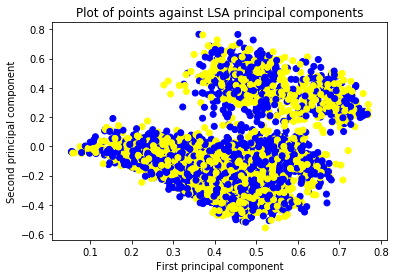

In [30]:
# Plot scatter plot of points %pylab inline
import matplotlib.pyplot as plt
%pylab inline
figure()
plt.scatter(xs,ys, color=['blue', 'yellow'])
xlabel('First principal component')
ylabel('Second principal component')
title('Plot of points against LSA principal components')
show()

# Compute Similarity

In [31]:
# the matrix product contains all the dot products of the terms
similarity = np.asarray(np.asmatrix(dtm_lsa) * np.asmatrix(dtm_lsa).T) 
pd.DataFrame(similarity,index=train.tweet_text, columns=train.tweet_text).head(10)

tweet_text,"USRTOK liebe corinna, wir würden dich gerne als moderatorin für uns gewinnen! wärst du begeisterbar?","USRTOK sie haben ja auch recht. unser tweet war etwas missverständlich. dass das bverfg sachleistungen nicht ausschließt, kritisieren wir.",USRTOK fröhlicher gruß aus der schönsten stadt der welt theo ⚓️,USRTOK amis hätten alles und jeden gewählt...nur hillary wollten sie nicht und eine fortsetzung von obama-politik erst recht nicht..!,USRTOK kein verläßlicher verhandlungspartner. nachkarteln nach den sondierzngsgesprächen - schickt diese stümper #spd in die versenkung.,"USRTOK ja, aber wo widersprechen die zahlen denn denen, die im von uns verlinkten artikel stehen? in unserem tweet geht es rein um subs. geschützte. 2017 ist der gesamte familiennachzug im vergleich zu 2016 - die zahlen, die hr. brandner bemüht - übrigens leicht rückläufig gewesen.",USRTOK 33 bis 45 habe ich noch gar nicht gelebt und es geht mir am arsch vorbei was in dieser zeit geschehen ist. ich lebe im heute und jetzt und nicht in der vergangenheit.,USRTOK USRTOK wieso? was findest du da unklar?,USRTOK euere afd hetze wirkt. da könnt ihr stolz sein bei #ard-fernsehen,"deutsche medien, halbwahrheiten und einseitige betrachtung, wie bei allen vom staat finanzierten ""billigen"" propagandainstitutionen 😜",...,USRTOK USRTOK unsere angie wird überall ausgebuht... |lbr| dies ist der grund warum sie öffentliche auftritte meidet und nur in geschlossenen räumen trällert,"während das sturmtief #frederike über #deutschland hinwegrauscht, lese ich die zahlreichen facebook-kommentare von #afd-sympathisanten, die #groening für unschuldig halten &amp; den #holocaust relativieren. der hiesige #antisemitismus müsste auch von einem sturm weggeweht werden!",wie viele schüler sind evangelisch? und wie viele schüler sind |lbr| ohne glaubensbekenntnis? dann erst werden eure zahlen vergleichbar.,USRTOK und wie reagiert die polizeiführung?,"USRTOK deshalb sprach ich vom wenden 😂😂😂 vorne, hinten, innen, außen - einen f. fanuar, einen für den februar usw. 12 stück 😂😂😂",gegens. zul. zu patenamt &amp; gegenseitige anerk. von firmung/konfirmation von #altkatholisch|er #synode mit großer mehrheit angen. #aksynode16,"USRTOK zu merkel fällt mir nur ein, ein mal verräterin, immer verräterin - selbstverliebt und immer des eigenen vorteils bedacht 🤢",USRTOK USRTOK ein richtiges zeichen unserer nachbarn...schleichende islamisierung sowie eine derartige umverteilung darf nicht unterstützt werden..niemals,"USRTOK ,honecker‘merkel macht uns zur ,ddr‘ klagen werden nicht angenommen,zeitungen sind gleichgeschaltet,die linken chaoten haben demonstrationsfreiheit,und die politiker der altparteien haben ihr schäfchen im trockenen und gehen in der schorfheide jagen!",warum wurden die g20-chaoten nicht sofort auf frischer tat verhaftet? |lbr| haben die polizisten nur gefilmt? waren sie zu feige für festnahmen?
tweet_text,,,,,,,,,,,,,,,,,,,,,
"USRTOK liebe corinna, wir würden dich gerne als moderatorin für uns gewinnen! wärst du begeisterbar?",1.000000,0.254749,0.023862,0.138919,0.071069,0.211866,-0.022258,0.502457,0.013578,0.075121,...,0.025517,0.153091,0.165835,0.207777,0.323135,0.037441,0.092948,0.051000,0.255402,0.314728
"USRTOK sie haben ja auch recht. unser tweet war etwas missverständlich. dass das bverfg sachleistungen nicht ausschließt, kritisieren wir.",0.254749,1.000000,0.026365,0.382729,0.117820,0.325437,0.186584,0.063223,0.024796,0.062201,...,0.245299,0.160289,0.088344,0.068229,0.283401,0.032967,0.151482,0.230677,0.299215,0.273927
USRTOK fröhlicher gruß aus der schönsten stadt der welt theo ⚓️,0.023862,0.026365,1.000000,0.022133,0.026993,0.044357,0.047713,0.013520,-0.018181,-0.011816,...,0.061673,0.008182,-0.005204,0.036699,-0.002370,-0.005268,0.023268,0.017798,0.090836,0.010784
USRTOK amis hätten alles und jeden gewählt...nur hillary wollten sie nicht und eine fortsetzung von obama-politik erst recht nicht..!,0.138919,0.382729,0.022133,1.000000,0.190871,0.197559,0.298467,0.02